# Problem statement: 
This data set is collected from recordings of 30 human subjects captured via smartphones enabled with embedded inertial sensors.
In this project, we calculate a model by which a smartphone can detect its owner’s activity precisely. For the dataset, 30 people were used to perform 6 different activities. Each of them was wearing a Samsung Galaxy SII on their waist. Using the smartphone’s embedded sensors (the accelerometer and the gyroscope), the user’s speed and acceleration were measured in 3-axial directions. We use the sensor’s data to predict user’s activity.

* Dataset is imbalanced. The data has 10299 rows and 561 variables.
* This is a multiclass-classification problem. 


# Workflow:
- Load the dataset
- Basic data processing

## 1) Local mode training, by using a subset of large dataset

## 2) Training on SageMaker Cloud:
   - Prepare data for SageMaker cloud training:
       - Convert data to .csv and .recordio types
       - Upload training and validation datasets to S3 bucket
       
   - Specify training algorithm Docker Image
   - Build the XGBoost model
   - Specify training data location and optionally, validation data location
   - Train the model on SageMaker cloud
   - Deploy the model, and run real-time predictions
   - Evaluate the model (by calculating confusion matrix and f1 score)   





In [1]:
# Istall XGBoost package and update numpy (for the local mode):
!conda install -y -c conda-forge xgboost
!conda update -y numpy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |           py36_1         139 KB  conda-forge

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0      --> 2018.8.24-ha4d7672_0 conda-forge
    certifi:         2018.8.24-py36_1  --> 2018.8.24-py36_1     conda-forge
    openssl:         1.0.2p-h14c3975_0 --> 1.0.2p-h470a237_0    conda-forge


certifi 2018.8.24: ##################################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environmen

In [2]:
import sklearn
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

In [3]:
df=pd.read_csv('humanActivityRecognition_All.csv', sep = ',')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 562 entries, Label to 560
dtypes: float64(561), int64(1)
memory usage: 31.5 MB


In [4]:
# Data is slightly imbalanced:
df['Label'].value_counts()


6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: Label, dtype: int64

# Data Preparation/Cleaning:

In [5]:
# Sampling this large dataset, to save memory on S3:
from sklearn.model_selection import train_test_split
df_sampled, _ = train_test_split(df, test_size=0.75, random_state=42, shuffle=True, stratify=df['Label'])

In [6]:
# Hint: For the Multiclassification problem label need to be 0 to num_class-1
X=df_sampled.drop(['Label'], axis=1)
y=df_sampled['Label']-1

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [7]:
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1) 

In [8]:
# Write to SageMaker Notebook Instance: It is saved in the folder where this ipynb was created

df_train.to_csv('humanActivityRecognition_train.csv', index=False, header=False)
df_test.to_csv('humanActivityRecognition_test.csv', index=False, header=False)

In [9]:
pd.read_csv('humanActivityRecognition_train.csv', header=None).head(3)

,0,1,2,3,4,5,6,7,8,9,...,552,553,554,555,556,557,558,559,560,561
0,5,0.267642,-0.021929,-0.105595,-0.955709,-0.953523,-0.977972,-0.955550,-0.949037,-0.976497,...,0.284104,-0.801001,-0.955014,0.008229,0.213895,0.039324,-0.479638,0.584896,-0.142527,-0.878684
1,1,0.321116,-0.062431,-0.064911,-0.413155,-0.103221,-0.275155,-0.462657,-0.102763,-0.194834,...,-0.000657,-0.567265,-0.884542,-0.300962,0.195643,0.869331,-0.731006,-0.780705,0.248223,0.039572
2,2,0.467579,-0.058709,-0.187236,0.079062,-0.119702,-0.139089,0.069725,-0.121437,-0.165415,...,-0.194227,-0.372101,-0.816201,-0.728161,0.310975,0.963024,-0.201127,-0.708366,0.214585,0.188085


#  1) Local Mode Training (usually on a subset of large dataset): 

In [10]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

hyper_params={'max_depth': 6, 
              'subsample': 0.7}

model=XGBClassifier(**hyper_params, seed=42) 
kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted')

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.97217443 0.95785393 0.93911416] 

Accuracy: 0.96 (+/- 0.01)


# 2)  Training on SageMaker Cloud

# preparing data for SageMaker cloud training: 
    - Converting data to .csv or .recodio types
    - Uploading training & validation datasets to S3 bucket

In [11]:
# Specify the Keys and Location of Train & Test datasets in S3:
bucket_name = 'roohi-ml-sagemaker'
training_file_key = 'humanActivityRecognition/humanActivityRecognition_train.csv'
test_file_key = 'humanActivityRecognition/humanActivityRecognition_test.csv'

s3_model_output_location = r's3://{0}/humanActivityRecognition/model'.format(bucket_name)
s3_training_file_location = r's3://{0}/{1}'.format(bucket_name,training_file_key)
s3_test_file_location = r's3://{0}/{1}'.format(bucket_name,test_file_key)

In [12]:
# Write and Reading from S3 is just as easy
# files are referred as objects in S3. File name is referred as key name in S3.
# Files stored in S3 are automatically replicated across 3 different availability zones in the region where the bucket was created.
# http://boto3.readthedocs.io/en/latest/guide/s3.html

def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [13]:
write_to_s3('humanActivityRecognition_train.csv', bucket_name, training_file_key)
write_to_s3('humanActivityRecognition_test.csv', bucket_name, test_file_key)

   # Training Algorithm Docker Image:  
    Note: AWS Maintains a separate image for every region and algorithm

In [14]:
# Registry Path for algorithms provided by SageMaker
#  https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

In [15]:
role = get_execution_role()

# This role contains the permissions needed to train, deploy models
# SageMaker Service is trusted to assume this role
print(role)

arn:aws:iam::928921801380:role/service-role/AmazonSageMaker-ExecutionRole-20180831T120207


# Build model: 

In [16]:
sess = sagemaker.Session()

In [17]:
# Access appropriate algorithm container image
#  Specify how many instances to use for distributed training and what type of machine to use
#  Finally, specify where the trained model artifacts needs to be stored
#   Reference: http://sagemaker.readthedocs.io/en/latest/estimators.html
#    Optionally, give a name to the training job using base_job_name

estimator = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role,
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.xlarge',
                                       output_path=s3_model_output_location,
                                       sagemaker_session=sess,
                                       base_job_name ='xgboost-humanActivityRecognition-Train')

In [18]:
# Specify hyper parameters that appropriate for the training algorithm
# Take a look this table for metrics & parameters:   https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html

hyper_params={'subsample': 0.7,
              'eval_metric':'merror',          
              'objective':'multi:softmax',
              'seed':42, 
              'num_round':70,
              'num_class':6 }

estimator.set_hyperparameters(**hyper_params)

estimator.hyperparameters()

{'subsample': 0.7,
 'eval_metric': 'merror',
 'objective': 'multi:softmax',
 'seed': 42,
 'num_round': 70,
 'num_class': 6}

#    Specify Training Data Location and Optionally, Validation Data Location:

In [19]:
# content type can be libsvm or csv for XGBoost
training_input_config = sagemaker.session.s3_input(s3_data=s3_training_file_location, content_type="csv")
test_input_config = sagemaker.session.s3_input(s3_data=s3_test_file_location, content_type="csv")

print(training_input_config.config)
print(test_input_config.config)

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/humanActivityRecognition/humanActivityRecognition_train.csv'}}, 'ContentType': 'csv'}
{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/humanActivityRecognition/humanActivityRecognition_test.csv'}}, 'ContentType': 'csv'}


# Train the model on SM cloud:

In [20]:
# XGBoost supports "train", "validation" channels
# Reference: Supported channels by algorithm    
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

estimator.fit({'train': training_input_config, 'validation': test_input_config})

INFO:sagemaker:Creating training-job with name: xgboost-humanActivityRecognition-Train-2018-09-04-02-37-35-808


...................
Arguments: train
[2018-09-04:02:40:40:INFO] Running standalone xgboost training.
[2018-09-04:02:40:40:INFO] File size need to be processed in the node: 11.89mb. Available memory size in the node: 8608.53mb
[2018-09-04:02:40:40:INFO] Determined delimiter of CSV input is ','
[02:40:40] S3DistributionType set as FullyReplicated
[02:40:40] 1286x561 matrix with 721446 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-09-04:02:40:40:INFO] Determined delimiter of CSV input is ','
[02:40:40] S3DistributionType set as FullyReplicated
[02:40:40] 552x561 matrix with 309672 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[02:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[02:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[02:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1

[02:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[02:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[39]#011train-merror:0#011validation-merror:0.030797
[02:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[02:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[02:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[02:40:45] src/tree/updater_prune.cc:74: tree pruning end, 


Billable seconds: 100


## Deploy Model & Run Real-time Predictions:

In [21]:
# Ref: http://sagemaker.readthedocs.io/en/latest/estimators.html
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge',
                             endpoint_name = 'xgboost-humanActivityRecognition-Train')

INFO:sagemaker:Creating model with name: xgboost-2018-09-04-02-41-18-081
INFO:sagemaker:Creating endpoint with name xgboost-humanActivityRecognition-Train


----------------------------------------------------------------!

In [22]:
# Run Predictions
from sagemaker.predictor import csv_serializer, json_deserializer

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = None

In [23]:
df_test = pd.read_csv('humanActivityRecognition_test.csv', header=None)

X_test=df_test.loc[0:, 1:].as_matrix()
y_test=df_test.loc[0:, 0].as_matrix()

In [29]:
# For large number of predictions, we can split the input data and Query the prediction service.
# array_split is convenient to specify how many splits are needed
predictions = []
for arr in np.array_split(X_test, 10):
    result = predictor.predict(arr)
    result = result.decode("utf-8")
    result = result.split(',')
    print (arr.shape)
    predictions += [float(r) for r in result]

(56, 561)
(56, 561)
(55, 561)
(55, 561)
(55, 561)
(55, 561)
(55, 561)
(55, 561)
(55, 561)
(55, 561)


# Evaluate the initial model:

In [30]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score

report=classification_report(y_test, predictions)
print(report)

             precision    recall  f1-score   support

          0       1.00      0.99      0.99        92
          1       0.98      1.00      0.99        81
          2       1.00      0.99      0.99        74
          3       0.96      0.93      0.94        96
          4       0.93      0.97      0.95       103
          5       1.00      0.99      1.00       106

avg / total       0.98      0.98      0.98       552



Confusion matrix, without normalization
[[ 91   1   0   0   0   0]
 [  0  81   0   0   0   0]
 [  0   1  73   0   0   0]
 [  0   0   0  89   7   0]
 [  0   0   0   3 100   0]
 [  0   0   0   1   0 105]]
Normalized confusion matrix
[[0.99 0.01 0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.  ]
 [0.   0.01 0.99 0.   0.   0.  ]
 [0.   0.   0.   0.93 0.07 0.  ]
 [0.   0.   0.   0.03 0.97 0.  ]
 [0.   0.   0.   0.01 0.   0.99]]


<Figure size 432x288 with 0 Axes>

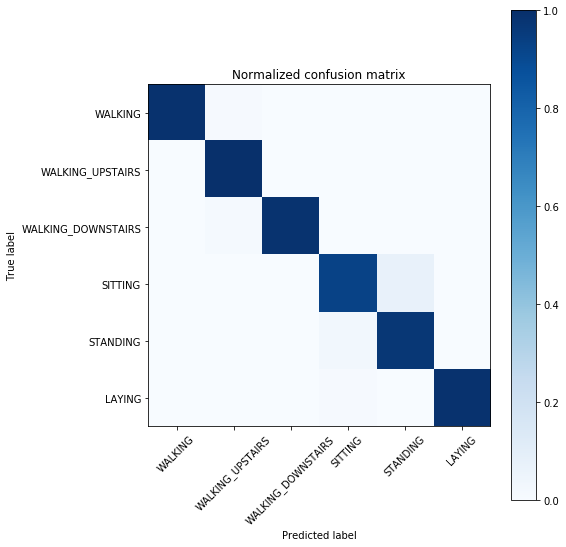

In [32]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()